**Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time

import conv_deconv_blocks as cdb
import data_processing as dp
import conv_deconv_models as md
import cris_utils as cu

**Tensorflow GPU Verification**

In [2]:
print("Versión de tensorflow: " + str(tf.__version__))
print("Comprobación de la GPU:",tf.config.experimental.list_physical_devices('GPU'),"\n")

Versión de tensorflow: 2.1.0
Comprobación de la GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 



In [3]:
#run_description = sys.argv[1] if len(sys.argv)>1 else "DEFAULT"
run_description = "DEFAULT"

# CVAE

**Model Arquitecture**

In [4]:
N_H = 64
N_W = 64
N_C = 1

cvae_enc_convs = [(16,True,cdb.lr_act,3,2),
              (32,False,cdb.lr_act,3,2),
              (64,True,cdb.lr_act,3,2),
             (128,False,cdb.lr_act,3,2),
             (256,False,cdb.lr_act,3,2)]

cvae_dec_deconvs = [(512,True,cdb.r_act,3,2),
               (256,True,cdb.r_act,3,2),
               (128,True,cdb.r_act,3,2),
               (64,True,cdb.r_act,3,2),
               (N_C,False,cdb.th_act,3,2)]

n_cvae_conv_ls = len(cvae_enc_convs)
n_cvae_deconv_ls = len(cvae_dec_deconvs)

max_layers = cu.max_conv_deconv_layers(N_H)
assert (n_cvae_conv_ls<=max_layers and n_cvae_deconv_ls<=max_layers), "Incorrect number of layers for cvae model"

config = {
    md.batch_size_k: 16,
    md.latent_dim_k: 100,
    md.data_dir_patt_k: ["data_FVC2006","png"],
    md.fps_shape_k: (N_H,N_W,N_C)
}

cvae_enc_config = {
    cdb.fps_shape_k: config[md.fps_shape_k],
    cdb.enc_dec_lys_info_k: cvae_enc_convs,
    cdb.enc_fin_den_len_k: 2*config[md.latent_dim_k]
}

hw_f_v = N_H/np.power(2,n_cvae_deconv_ls)

cvae_dec_config = {
    cdb.dec_den_info_k: ([hw_f_v,hw_f_v,256],False,cdb.r_act,(config[md.latent_dim_k],)),
    cdb.enc_dec_lys_info_k: cvae_dec_deconvs,
}

for H,W = 64, # deconv layers and # conv layers <= 6
(# conv layers, heigh,width of last enc volume)
(# deconv layers, heigh,width of first dec volume)
[(1, 32), (2, 16), (3, 8), (4, 4), (5, 2), (6, 1)] 



**Data Preparation**

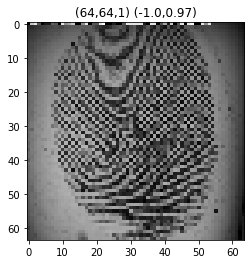

In [5]:
ds_data_dirs = dp.load_process_fp_dataset(config[md.data_dir_patt_k],config[md.fps_shape_k],config[md.batch_size_k])
l = list(ds_data_dirs.as_numpy_iterator())
cu.imshow(l[0][0,:])

**Creation of Model**

In [6]:
cvae = md.CVAE(cvae_enc_config,cvae_dec_config,config,run_description)

**CVAE Training Configuration**

In [7]:
cvae_train_conf = {
    md.num_epochs_k: 5,
    md.num_images_k: 5,
    md.checkpoints_frecuency_k: 5,
    md.use_latest_checkpoint_k: False,
    md.types_losses_k: [md.square_loss,md.kl_loss,md.ssim_loss],
    md.alphas_losses_k: [1.0,0.01,0.5],
    md.learning_rate_k: 0.0002,
    md.dataset_k: ds_data_dirs
}

**Model Training**

In [8]:
#cvae.train(cvae_train_conf)

# GAN_CVAE

**Model Arquitecture**

In [9]:
N_H = 64
N_W = 64
N_C = 1

cvae_enc_convs = [(16,True,cdb.lr_act,3,2),
              (32,False,cdb.lr_act,3,2),
              (64,True,cdb.lr_act,3,2),
             (128,False,cdb.lr_act,3,2),
             (256,False,cdb.lr_act,3,2)]

cvae_dec_deconvs = [(512,True,cdb.r_act,3,2),
               (256,True,cdb.r_act,3,2),
               (128,True,cdb.r_act,3,2),
               (64,True,cdb.r_act,3,2),
               (N_C,False,cdb.th_act,3,2)]

gan_disc_convs = [(64,False,cdb.lr_act,3,2),
              (128,True,cdb.lr_act,3,2),
              (256,True,cdb.lr_act,3,2),
             (512,True,cdb.lr_act,3,2)]

n_cvae_conv_ls = len(cvae_enc_convs)
n_cvae_deconv_ls = len(cvae_dec_deconvs)

max_layers = cu.max_conv_deconv_layers(N_H)
assert (n_cvae_conv_ls<=max_layers and n_cvae_deconv_ls<=max_layers), "Incorrect number of layers for cvae model"

config = {
    md.batch_size_k: 16,
    md.latent_dim_k: 100,
    md.data_dir_patt_k: ["data_FVC2006","png"],
    md.fps_shape_k: (N_H,N_W,N_C)
}

cvae_enc_config = {
    cdb.fps_shape_k: config[md.fps_shape_k],
    cdb.enc_dec_lys_info_k: cvae_enc_convs,
    cdb.enc_fin_den_len_k: 2*config[md.latent_dim_k]
}

hw_f_v = N_H/np.power(2,n_cvae_deconv_ls)

cvae_dec_config = {
    cdb.dec_den_info_k: ([hw_f_v,hw_f_v,256],False,cdb.r_act,(config[md.latent_dim_k],)),
    cdb.enc_dec_lys_info_k: cvae_dec_deconvs,
}

gan_disc_config = {
    cdb.fps_shape_k: config[md.fps_shape_k],
    cdb.enc_dec_lys_info_k: gan_disc_convs,
    cdb.enc_fin_den_len_k: 1
}

for H,W = 64, # deconv layers and # conv layers <= 6
(# conv layers, heigh,width of last enc volume)
(# deconv layers, heigh,width of first dec volume)
[(1, 32), (2, 16), (3, 8), (4, 4), (5, 2), (6, 1)] 



**Creation of Model**

In [10]:
gan_cvae = md.GAN_CVAE(cvae_enc_config,cvae_dec_config,gan_disc_config,config,run_description)

**GAN_CVAE Training Configuration**

In [11]:
gan_cvae_train_conf = {
    md.num_epochs_k: 5,
    md.num_images_k: 5,
    md.checkpoints_frecuency_k: 5,
    md.use_latest_checkpoint_k: False,
    md.disc_learning_rate_k: 0.0002,
    md.gen_learning_rate_k: 0.0002,
    md.dataset_k: ds_data_dirs,
}

**Model Training**

In [12]:
gan_cvae.train(gan_cvae_train_conf)
assert(False)

GAN CVAE training started


ValueError: Expected scalar shape, saw shape: (8,).

# GAN

**Model Arquitecture**

In [ ]:
N_H = 64
N_W = 64
N_C = 1

gan_gen_deconvs = [(512,True,cdb.r_act,3,2),
               (256,True,cdb.r_act,3,2),
               (128,True,cdb.r_act,3,2),
               (64,True,cdb.r_act,3,2),
               (N_C,False,cdb.th_act,3,2)]

gan_disc_convs = [(64,False,cdb.lr_act,3,2),
              (128,True,cdb.lr_act,3,2),
              (256,True,cdb.lr_act,3,2),
             (512,True,cdb.lr_act,3,2)]

n_gan_gen_deconv_ls = len(gan_gen_deconvs)
n_cvae_conv_ls = len(cvae_enc_convs)

max_layers = cu.max_conv_deconv_layers(N_H)
assert (n_cvae_conv_ls<=max_layers and n_gan_gen_deconv_ls<=max_layers), "Incorrect number of layers for cvae model"

config = {
    md.batch_size_k: 16,
    md.latent_dim_k: 100,
    md.data_dir_patt_k: ["data_FVC2006","png"],
    md.fps_shape_k: (N_H,N_W,N_C)
}

hw_f_v = N_H/np.power(2,n_cvae_deconv_ls)

gan_gen_config = {
    cdb.dec_den_info_k: ([hw_f_v,hw_f_v,256],False,cdb.r_act,(config[md.latent_dim_k],)),
    cdb.enc_dec_lys_info_k: gan_gen_deconvs,
}

gan_disc_config = {
    cdb.fps_shape_k: config[md.fps_shape_k],
    cdb.enc_dec_lys_info_k: gan_disc_convs,
    cdb.enc_fin_den_len_k: 1
}

**Creation of Model**

In [ ]:
gan = md.GAN(gan_gen_config,gan_disc_config,config,run_description)

**GAN Training Configuration**

In [ ]:
gan_train_conf = {
    md.num_epochs_k: 5,
    md.num_images_k: 5,
    md.checkpoints_frecuency_k: 5,
    md.use_latest_checkpoint_k: False,
    md.disc_learning_rate_k: 0.0002,
    md.gen_learning_rate_k: 0.0002,
    md.dataset_k: ds_data_dirs,
}

**Model Training**

In [ ]:
gan.train(gan_train_conf)

**Remove Files**

In [ ]:
import cris_utils as cu
code_dir = "C:/Users/Y50/Documents/Universidad/Tesis/Codigo/Output_data/*"
cu.delete_All(code_dir)

**Test Code**